# Predicción del precio de la leche

Este notebook implementa un flujo de análisis y predicción del precio promedio por litro de leche.

Objetivos:
- Preparar series temporales y crear variables exógenas (incluyendo rezagos).
- Entrenar y comparar varios modelos (ARIMAX, SARIMAX, Prophet, ElasticNet, XGBoost).
- Evaluar usando métricas (MAE, MSE, RMSE, R²) y visualizar predicciones.

Entradas:
- `Data/base_con_dolar.csv` y `Data/base_con_dolar_gasolina.csv`

Salidas:
- CSV con métricas por modelo (`resultados_modelos_leche.csv`, `metricas_modelos_E4.csv`).
- Gráficas comparativas de predicciones vs reales.

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from prophet import Prophet


## Librerías y dependencias

Este bloque importa las librerías principales:
- pandas/numpy para manipulación de datos,
- matplotlib para visualización,
- statsmodels SARIMAX para modelos ARIMA/SARIMAX,
- Prophet para modelado (Facebook/Meta Prophet),
- sklearn para métricas y modelos de regresión.

Asegúrate de tener instaladas las dependencias (statsmodels, prophet, xgboost, scikit-learn).

In [192]:
def preparar_serie(df, vars_exog, rezagos=[1,2,3,4]):
    # Crear FECHA (día 1)
    df = df.copy()
    df['FECHA'] = pd.to_datetime(
        dict(year=df['ano'], month=df['mes'], day=1)
    )

    # Selección mínima
    columnas = ['FECHA', 'precio promedio por litro', 'precio_dolar', 'ipc'] + vars_exog
    df = df[columnas]

    # Renombrar a nombres estándar
    df = df.rename(columns={
        'precio promedio por litro': 'LECHE',
        'precio_dolar': 'DOLAR',
        'ipc': 'IPC',
        'precio_promedio_biodiesel': 'BIODIESEL',
        'precio_promedio_corriente': 'CORRIENTE'
    })

    # Agregación temporal
    df = df.groupby('FECHA', as_index=False).mean()
    df = df.sort_values('FECHA').set_index('FECHA').asfreq('MS')

    # Variables exógenas base + adicionales
    vars_base = ['DOLAR', 'IPC']
    vars_extra = ['BIODIESEL', 'CORRIENTE'] if 'BIODIESEL' in df.columns else []
    vars_lag = vars_base + vars_extra

    # Crear rezagos
    for var in vars_lag:
        for lag in rezagos:
            df[f'{var}_L{lag}'] = df[var].shift(lag)

    df = df.interpolate().dropna()

    return df


### Función preparar_serie

Entrada:
- df: DataFrame con al menos columnas 'ano', 'mes', 'precio promedio por litro', 'precio_dolar', 'ipc'.
- vars_exog: lista de variables exógenas adicionales que se mantendrán.
- rezagos: lags que se crearán (por defecto [1,2]).

Salida:
- DataFrame indexado por 'FECHA' con la serie temporal mensual y las columnas de exógenas y sus rezagos.

Pasos principales:
- Construcción de fecha, selección y renombrado de columnas, agregación a nivel mensual, creación de rezagos e interpolación.

In [193]:
base_dolar = pd.read_csv("Data/base_con_dolar.csv")
base_gas   = pd.read_csv("Data/base_con_dolar_gasolina.csv")


### Carga de datos

Se cargan dos bases:
- `base_con_dolar.csv`: contiene la serie principal y variables macro (e.g., DÓLAR, IPC).
- `base_con_dolar_gasolina.csv`: versión con información de gasolina usada en un escenario específico.

Asegúrate de que la ruta `Data/` existe y contiene los archivos.

In [194]:
# LIMPIEZA ROBUSTA DE NOMBRES DE COLUMNAS
def normalizar_columnas(df):
    df.columns = (
        df.columns
        .str.strip()        # quita espacios
        .str.lower()        # minúsculas
        .str.replace('á','a')
        .str.replace('é','e')
        .str.replace('í','i')
        .str.replace('ó','o')
        .str.replace('ú','u')
        .str.replace('ñ','n')
    )
    return df

base_dolar = normalizar_columnas(base_dolar)
base_gas   = normalizar_columnas(base_gas)

print(base_dolar.columns)


Index(['ano', 'mes', 'nombre departamento', 'codigo departamento',
       'nombre municipio', 'codigo municipio', 'precio promedio por litro',
       'ipc', 'precio_dolar'],
      dtype='object')


### Normalización de nombres de columnas

Se normalizan columnas para evitar problemas por acentos, mayúsculas y espacios. Esto facilita el renombrado y selección posterior.

In [195]:
# Escenario 1: Completo
E1 = preparar_serie(base_dolar, vars_exog=[])

# Corte exacto en febrero de 2019
fecha_corte = '2019-02-01'

# Escenario 2: Pre-pandemia (hasta enero 2019)
E2 = E1[E1.index < fecha_corte]

# Escenario 3: Post-pandemia (desde febrero 2019)
E3 = E1[E1.index >= fecha_corte]

# Escenario 4: Gasolina (2021–2024)
E4 = preparar_serie(
    base_gas,
    vars_exog=[]
)
E4 = E4[E4.index.year >= 2021]



### Definición de escenarios

- E1: serie completa
- E2: hasta antes de la pandemia (corte: 2019-02-01) -> pre-pandemia
- E3: desde la pandemia (2019-02-01 en adelante) -> post-pandemia
- E4: serie específica para gasolina (2021 en adelante)

Estos escenarios permiten evaluar si la dinámica cambia entre periodos.

In [196]:
from statsmodels.tsa.seasonal import STL

def descomponer_stl(df, titulo):
    stl = STL(df['LECHE'], period=12, robust=True)
    res = stl.fit()
    
    res.plot()
    plt.suptitle(titulo)
    plt.show()


### Análisis de estacionalidad con STL

La función `descomponer_stl` utiliza STL para descomponer la serie en tendencia, estacionalidad y residual. Periodo = 12 (mensual).

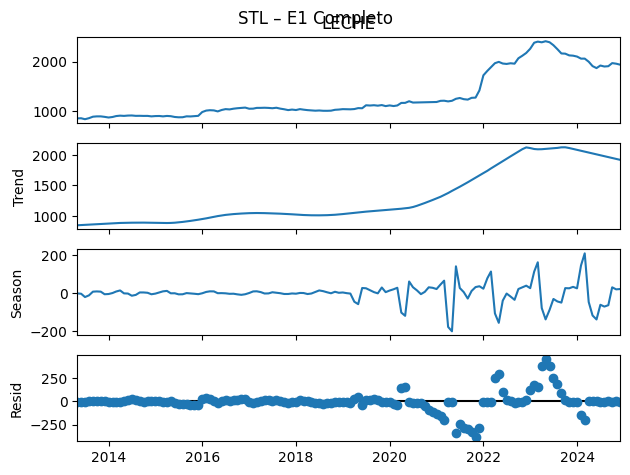

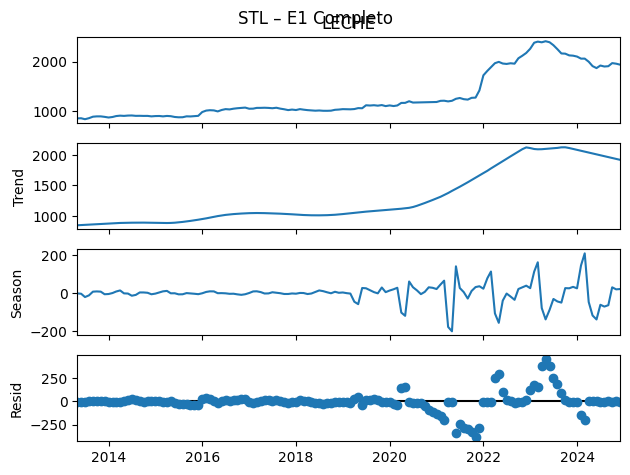

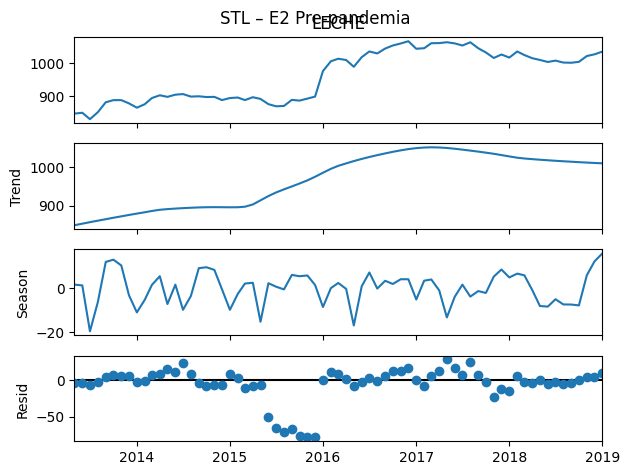

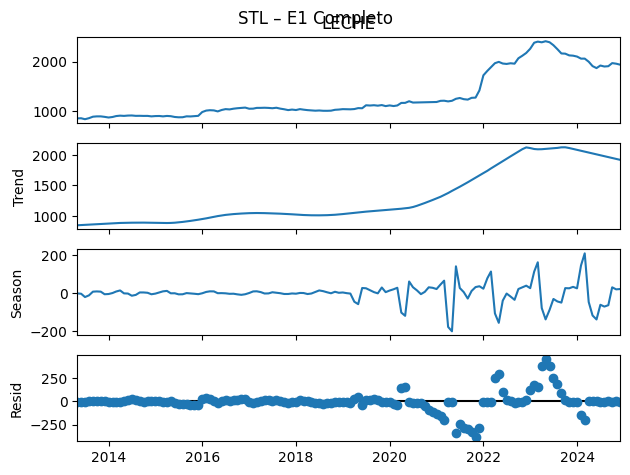

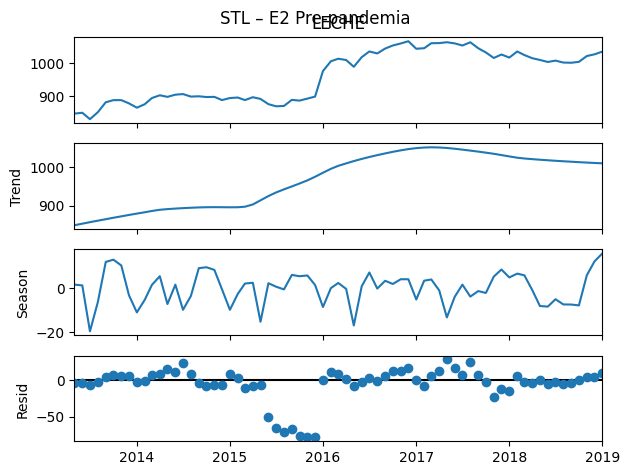

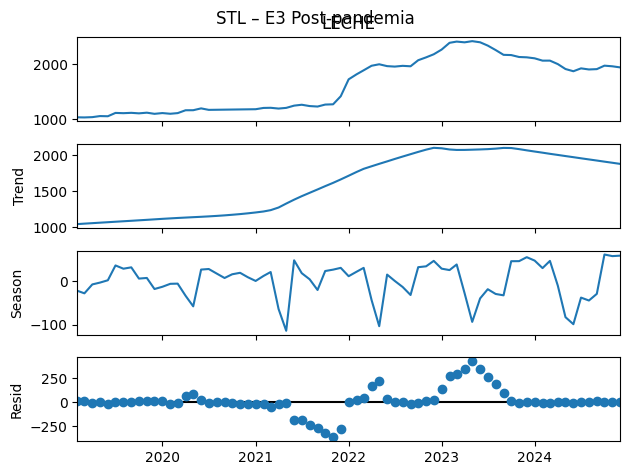

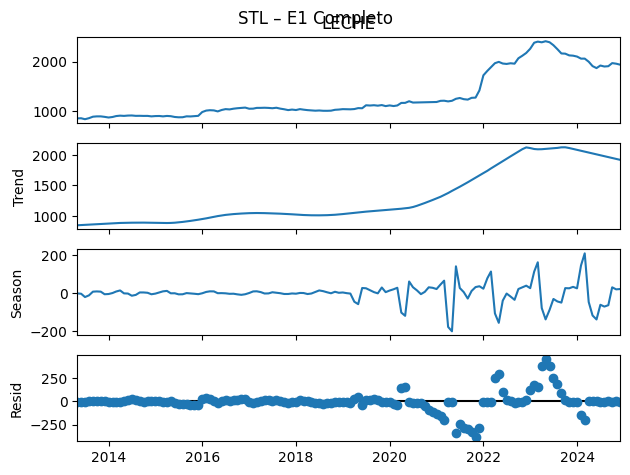

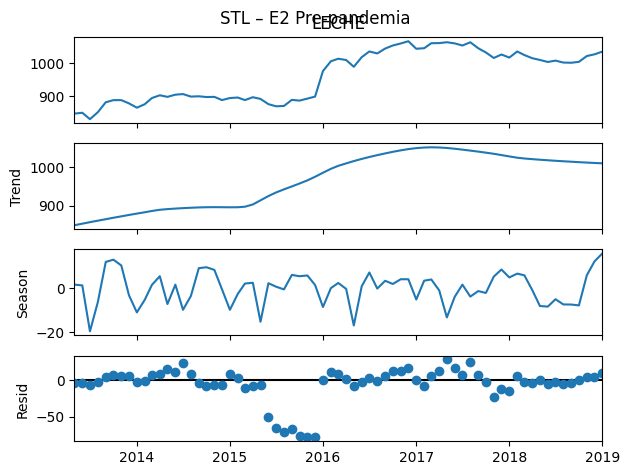

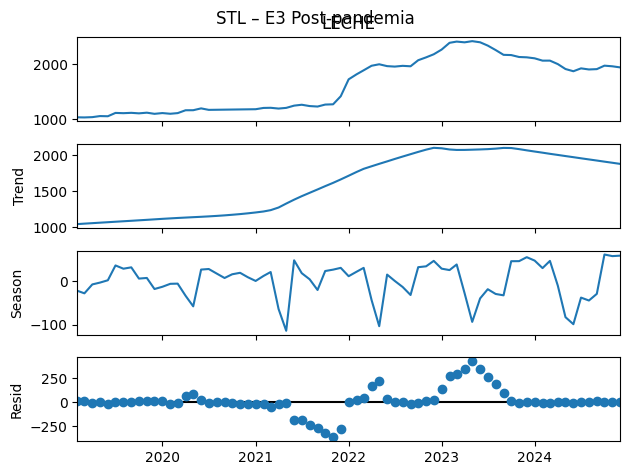

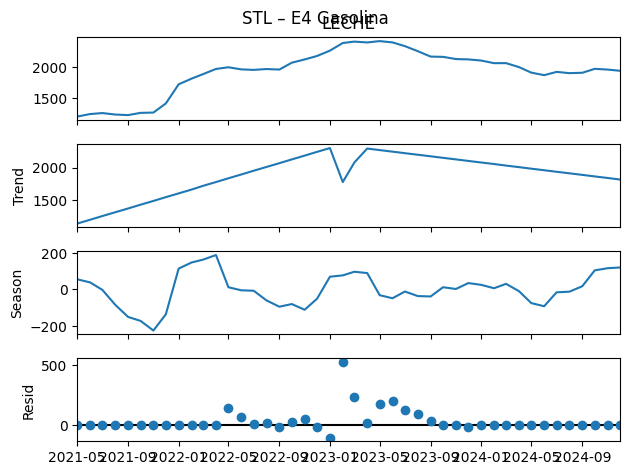

In [197]:
descomponer_stl(E1, 'STL – E1 Completo')
descomponer_stl(E2, 'STL – E2 Pre-pandemia')
descomponer_stl(E3, 'STL – E3 Post-pandemia')
descomponer_stl(E4, 'STL – E4 Gasolina')

In [198]:
def metricas(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }


### Métricas de evaluación

Se definen las métricas estándar: MAE, MSE, RMSE y R² para comparar modelos.

In [199]:
def entrenar_arimax(df, vars_exog):
    n_test = 12
    exog = [c for c in df.columns if c != 'LECHE']
    
    train, test = df.iloc[:-n_test], df.iloc[-n_test:]
    
    modelo = SARIMAX(
        train['LECHE'],
        exog=train[exog],
        order=(1,1,1),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    res = modelo.fit(disp=False)
    pred = res.get_forecast(steps=n_test, exog=test[exog]).predicted_mean
    
    return pred, metricas(test['LECHE'], pred)


### Modelo ARIMAX

Entrena un SARIMAX sin componente estacional (order=(1,1,1)) usando variables exógenas. Se evalúa predicción de los últimos 12 meses.

In [200]:
def entrenar_sarimax(df):
    n_test = 12
    exog = [c for c in df.columns if c != 'LECHE']
    
    train, test = df.iloc[:-n_test], df.iloc[-n_test:]
    
    modelo = SARIMAX(
        train['LECHE'],
        exog=train[exog],
        order=(1,1,1),
        seasonal_order=(1,1,1,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    res = modelo.fit(disp=False)
    pred = res.get_forecast(steps=n_test, exog=test[exog]).predicted_mean
    
    return pred, metricas(test['LECHE'], pred)


### Modelo SARIMAX

SARIMAX con componente estacional (seasonal_order=(1,1,1,12)) para capturar estacionalidad anual en series mensuales.

In [201]:
def entrenar_prophet(df):
    df_p = df.reset_index().rename(columns={'FECHA':'ds','LECHE':'y'})
    
    m = Prophet()
    for col in df.columns:
        if col != 'LECHE':
            m.add_regressor(col)
    
    m.fit(df_p)
    
    future = df_p[['ds'] + [c for c in df.columns if c != 'LECHE']]
    forecast = m.predict(future)
    
    y_pred = forecast['yhat'].iloc[-12:].values
    y_true = df['LECHE'].iloc[-12:].values
    
    return y_pred, metricas(y_true, y_pred)


### Modelo Prophet

Se convierte la serie a formato `ds`/`y` y se agregan regresores exógenos (si existen). Prophet se usa en modo básico y devuelve predicción para los últimos 12 meses.

In [202]:
escenarios = {
    'E1 Completo': E1,
    'E2 Pre-pandemia': E2,
    'E3 Post-pandemia': E3,
    'E4 Gasolina': E4
}

resultados = []
predicciones = {}

for nombre, df in escenarios.items():
    pred_arimax, m_arimax = entrenar_arimax(df, [])
    pred_sarimax, m_sarimax = entrenar_sarimax(df)
    pred_prophet, m_prophet = entrenar_prophet(df)
    
    resultados += [
        {'Escenario': nombre, 'Modelo': 'ARIMAX', **m_arimax},
        {'Escenario': nombre, 'Modelo': 'SARIMAX', **m_sarimax},
        {'Escenario': nombre, 'Modelo': 'Prophet', **m_prophet}
    ]
    
    predicciones[nombre] = (df['LECHE'], pred_arimax, pred_sarimax, pred_prophet)


/home/mateo/Documents/Prediccion IA/proyecto/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mateo/Documents/Prediccion IA/proyecto/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
20:46:09 - cmdstanpy - INFO - Chain [1] start processing
20:46:09 - cmdstanpy - INFO - Chain [1] done processing
/home/mateo/Documents/Prediccion IA/proyecto/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mateo/Documents/Prediccion IA/proyecto/.venv/lib/python3.12/site-packages/statsmodels/base/mode

### Entrenamiento y evaluación por escenario

Se itera sobre los escenarios y se entrena cada modelo para evaluar su desempeño en cada partición de datos. Las predicciones y métricas se guardan para comparación.

In [203]:
df_resultados = pd.DataFrame(resultados)
df_resultados.to_csv("Resultados/resultados_modelos_leche.csv", index=False)
df_resultados


,Escenario,Modelo,MAE,MSE,RMSE,R2
0,E1 Completo,ARIMAX,162.010163,32859.138122,181.270897,-5.463070
1,E1 Completo,SARIMAX,350.765924,133507.351707,365.386578,-25.259584
2,E1 Completo,Prophet,133.184342,23165.139172,152.200983,-3.556355
3,E2 Pre-pandemia,ARIMAX,29.554103,1004.563366,31.694848,-5.789720
4,E2 Pre-pandemia,SARIMAX,23.910017,1024.674351,32.010535,-5.925648
5,E2 Pre-pandemia,Prophet,10.935430,152.205113,12.337144,-0.028736
6,E3 Post-pandemia,ARIMAX,166.252578,34521.472045,185.799548,-5.790034
7,E3 Post-pandemia,SARIMAX,488.494588,259874.373163,509.778749,-50.114736
8,E3 Post-pandemia,Prophet,87.227633,9997.689282,99.988446,-0.966447
9,E4 Gasolina,ARIMAX,152.986057,31731.139336,178.132365,-5.241203


Se exportan las métricas resultantes (`resultados_modelos_leche.csv`) para su revisión y uso posterior.

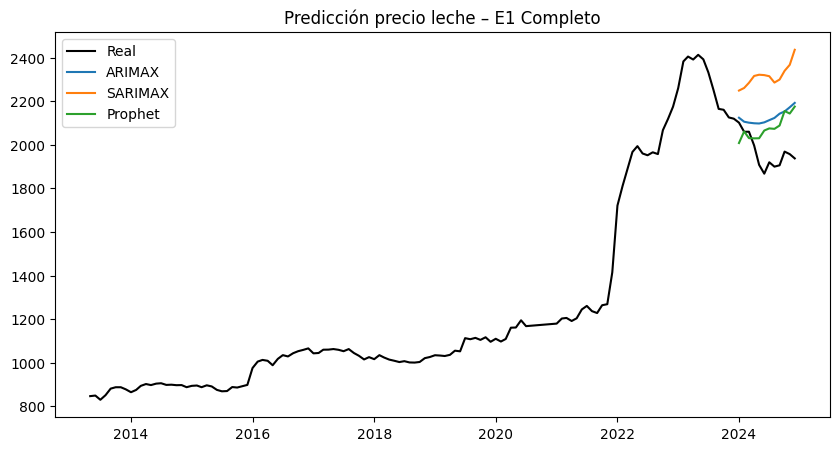

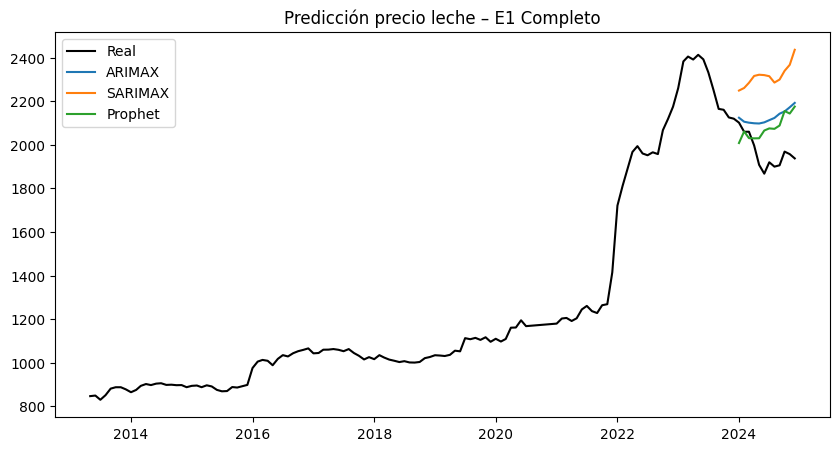

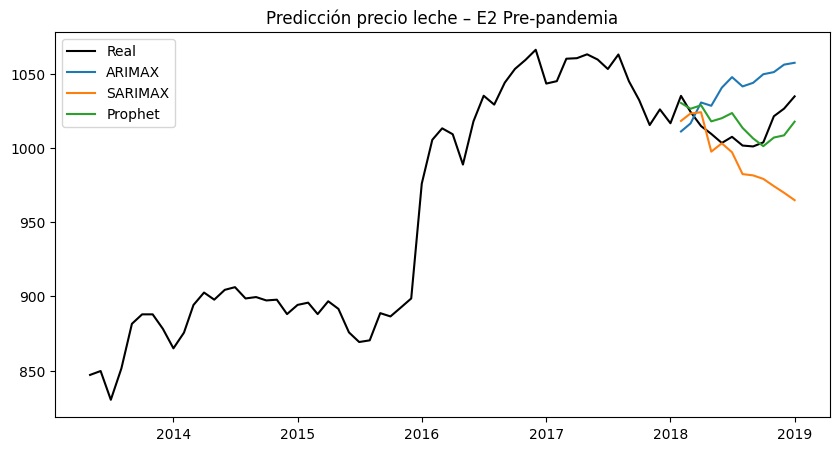

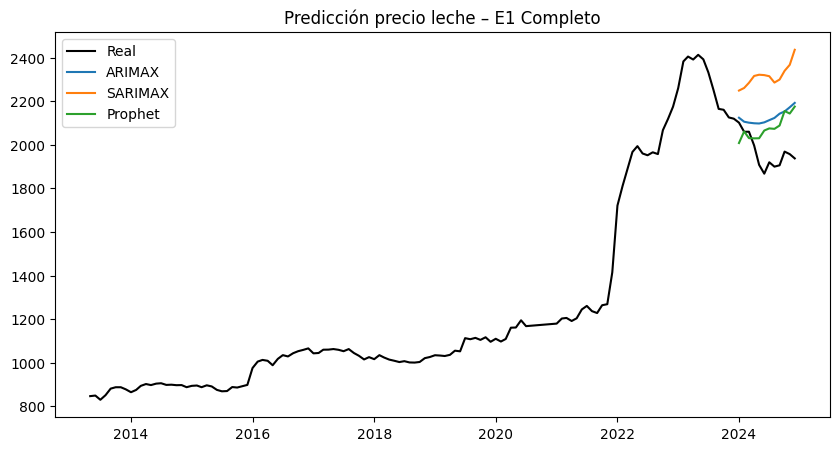

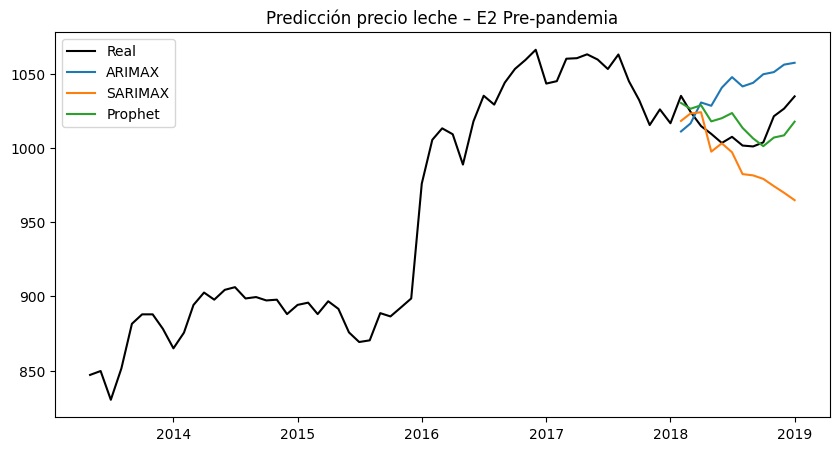

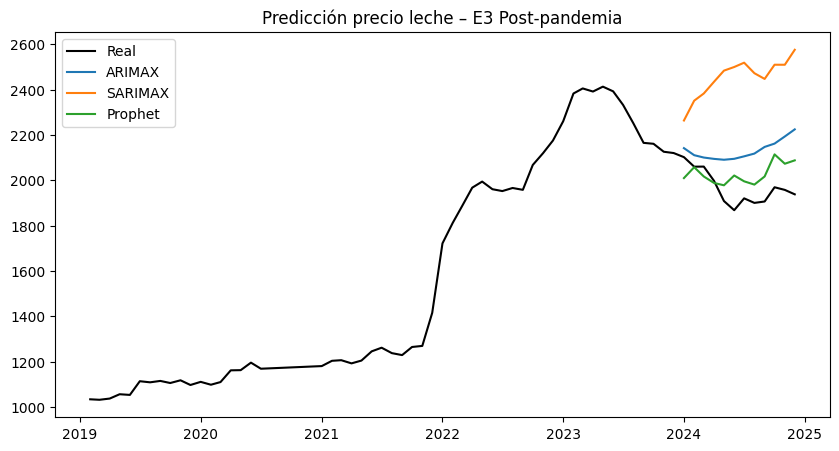

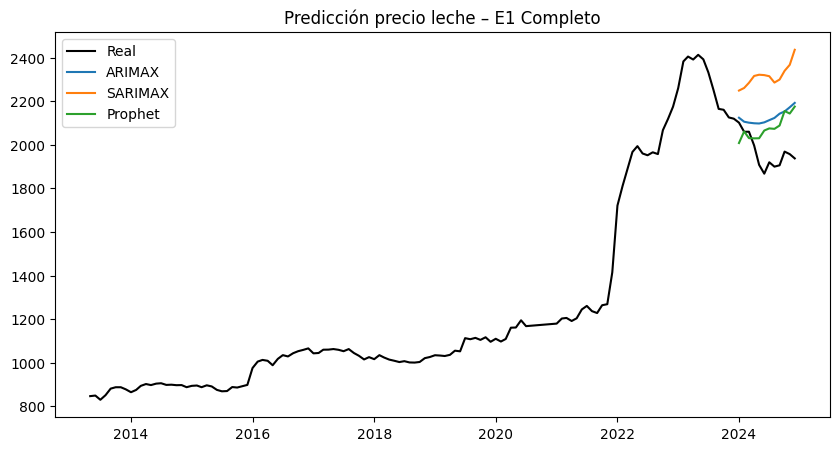

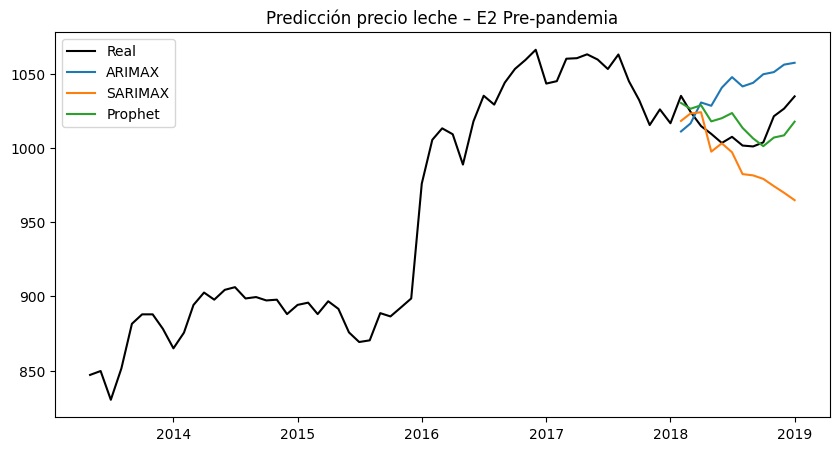

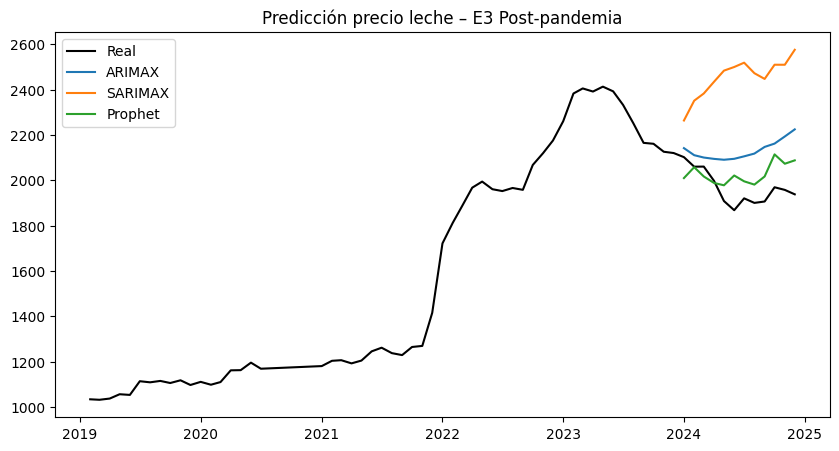

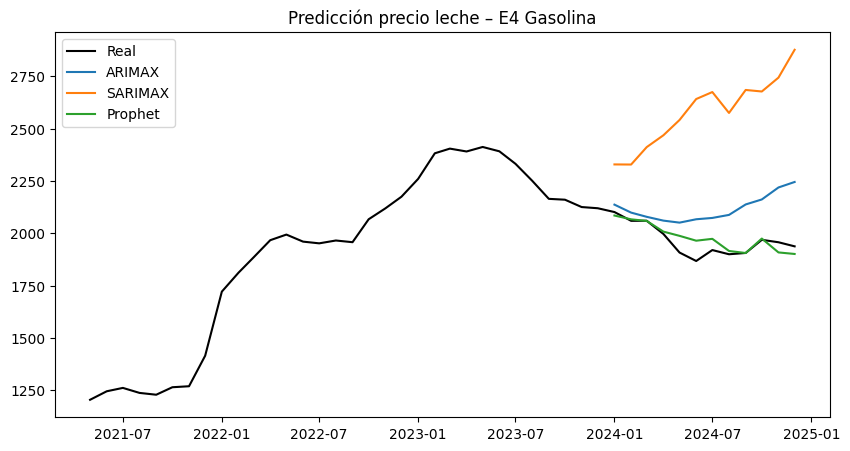

In [204]:
for nombre, (y, ar, sar, pro) in predicciones.items():
    plt.figure(figsize=(10,5))
    plt.plot(y.index, y, label='Real', color='black')
    plt.plot(y.index[-12:], ar, label='ARIMAX')
    plt.plot(y.index[-12:], sar, label='SARIMAX')
    plt.plot(y.index[-12:], pro, label='Prophet')
    plt.title(f'Predicción precio leche – {nombre}')
    plt.legend()
    plt.show()


### Visualización de predicciones

Se plotean las predicciones de cada modelo contra la serie real para cada escenario, facilitando comparación visual.

In [205]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def rolling_forecast_sarimax(df, exog_vars, window=36, steps=1):
    y = df['LECHE']
    X = df[exog_vars]
    
    preds, reales, fechas = [], [], []

    for i in range(window, len(df) - steps):
        y_train = y.iloc[i-window:i]
        X_train = X.iloc[i-window:i]
        X_test  = X.iloc[i:i+steps]

        modelo = SARIMAX(
            y_train,
            exog=X_train,
            order=(1,1,1),
            seasonal_order=(1,1,1,12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        pred = modelo.forecast(steps=steps, exog=X_test)
        
        preds.append(pred.values[0])
        reales.append(y.iloc[i])
        fechas.append(y.index[i])

    resultados = pd.DataFrame({
        'FECHA': fechas,
        'REAL': reales,
        'PRED': preds
    }).set_index('FECHA')

    return resultados


### Forecast rolling con SARIMAX

Implementa un esquema tipo walk-forward (rolling) con ventana `window` (por defecto 36 meses). Para cada punto se entrena SARIMAX y se predice `steps` pasos adelante. Útil para evaluar rendimiento out-of-sample en ventanas móviles.

In [206]:
exog_E4 = [c for c in E4.columns if '_L' in c]

rolling_E4 = rolling_forecast_sarimax(
    E4,
    exog_vars=exog_E4,
    window=36
)


/home/mateo/Documents/Prediccion IA/proyecto/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/mateo/Documents/Prediccion IA/proyecto/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mateo/Documents/Prediccion IA/proyecto/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/mateo/Documents/Prediccion IA/proyecto/.venv/lib/python3.12/site-packa

### Selección de variables exógenas para rolling forecast

Se usan variables que contienen `_L` (rezagos) como regresores en el rolling SARIMAX.

In [207]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def entrenar_elasticnet(df):
    X = df.drop(columns=['LECHE'])
    y = df['LECHE']

    split = int(len(df)*0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]

    modelo = Pipeline([
        ('scaler', StandardScaler()),
        ('enet', ElasticNet(alpha=0.05, l1_ratio=0.7))
    ])

    modelo.fit(X_train, y_train)
    pred = modelo.predict(X_test)

    return {
        'MAE': mean_absolute_error(y_test, pred),
        'RMSE': mean_squared_error(y_test, pred)**0.5,
        'R2': 1 - np.sum((y_test-pred)**2)/np.sum((y_test-y_test.mean())**2),
        'modelo': modelo,
        'X_test': X_test,
        'y_test': y_test,
        'pred': pred
    }


### ElasticNet (regresión penalizada)

Se usan pipeline con `StandardScaler` y `ElasticNet` (alpha y l1_ratio por defecto en el ejemplo). Se hace split 80/20 para validar.

In [208]:
res_enet_E4 = entrenar_elasticnet(E4)


In [209]:
from xgboost import XGBRegressor

def entrenar_xgboost(df):
    X = df.drop(columns=['LECHE'])
    y = df['LECHE']

    split = int(len(df)*0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]

    modelo = XGBRegressor(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    modelo.fit(X_train, y_train)
    pred = modelo.predict(X_test)

    return {
        'MAE': mean_absolute_error(y_test, pred),
        'RMSE': mean_squared_error(y_test, pred)**0.5,
        'R2': 1 - np.sum((y_test-pred)**2)/np.sum((y_test-y_test.mean())**2),
        'modelo': modelo,
        'X_test': X_test,
        'y_test': y_test,
        'pred': pred
    }


### XGBoost

Regresor basado en árboles con parámetros predefinidos (n_estimators, max_depth, learning_rate, etc.). También utiliza split 80/20.

In [210]:
res_xgb_E4 = entrenar_xgboost(E4)

In [211]:
# ===============================
# Unificar predicciones
# ===============================

# Serie real completa
serie_real = E4['LECHE']

# ElasticNet
enet_pred = pd.Series(
    res_enet_E4['pred'],
    index=res_enet_E4['X_test'].index,
    name='ElasticNet'
)

# XGBoost
xgb_pred = pd.Series(
    res_xgb_E4['pred'],
    index=res_xgb_E4['X_test'].index,
    name='XGBoost'
)

# Rolling SARIMAX
sarimax_pred = rolling_E4['PRED'].rename('Rolling_SARIMAX')


### Unificar predicciones

Se consolidan las series de predicción (ElasticNet, XGBoost, Rolling SARIMAX) para comparar en la misma gráfica.

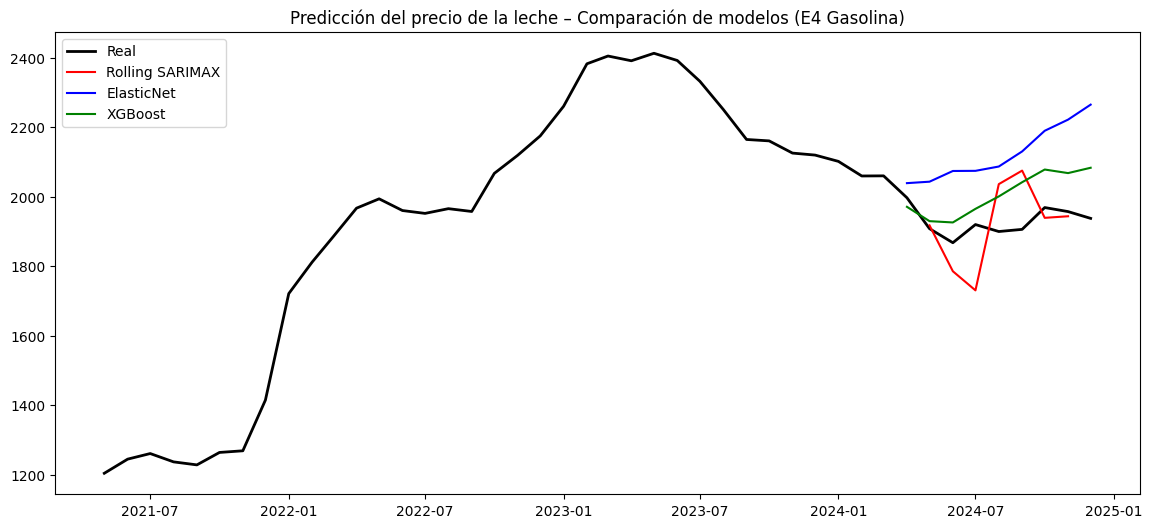

In [212]:
plt.figure(figsize=(14,6))

plt.plot(serie_real, label='Real', color='black', linewidth=2)

plt.plot(sarimax_pred, label='Rolling SARIMAX', color='red')
plt.plot(enet_pred, label='ElasticNet', color='blue')
plt.plot(xgb_pred, label='XGBoost', color='green')

plt.title('Predicción del precio de la leche – Comparación de modelos (E4 Gasolina)')
plt.legend()
plt.show()


### Gráfica comparativa final

Se visualizan las predicciones de los distintos modelos comparadas con la serie real.

In [213]:
def metricas(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': mean_squared_error(y_true, y_pred)**0.5,
        'R2': 1 - np.sum((y_true-y_pred)**2)/np.sum((y_true-y_true.mean())**2)
    }


### Métricas (segunda versión)

Se reitera la función `metricas` considerando una alternativa al cálculo del R² para garantía de consistencia.

In [214]:
resultados = []

# Rolling SARIMAX
m_sarimax = metricas(
    rolling_E4['REAL'],
    rolling_E4['PRED']
)
resultados.append({'Modelo':'Rolling SARIMAX', **m_sarimax})

# ElasticNet
m_enet = metricas(
    res_enet_E4['y_test'],
    res_enet_E4['pred']
)
resultados.append({'Modelo':'ElasticNet', **m_enet})

# XGBoost
m_xgb = metricas(
    res_xgb_E4['y_test'],
    res_xgb_E4['pred']
)
resultados.append({'Modelo':'XGBoost', **m_xgb})

tabla_resultados = pd.DataFrame(resultados)
tabla_resultados


,Modelo,MAE,MSE,RMSE,R2
0,Rolling SARIMAX,89.933097,12992.423542,113.984313,-11.568806
1,ElasticNet,195.817039,44196.944165,210.230693,-30.189295
2,XGBoost,83.740423,8960.144924,94.658042,-5.323075


### Consolidación de métricas

Se calculan y colocan en un DataFrame las métricas finales para cada modelo usando las predicciones relevantes.

In [215]:
tabla_resultados.to_csv('Resultados/metricas_modelos_E4.csv', index=False)


### Guardado de métricas

Se exporta `metricas_modelos_E4.csv` con resultados para E4.


CSV guardado: predicciones_E4_2024_onwards.csv


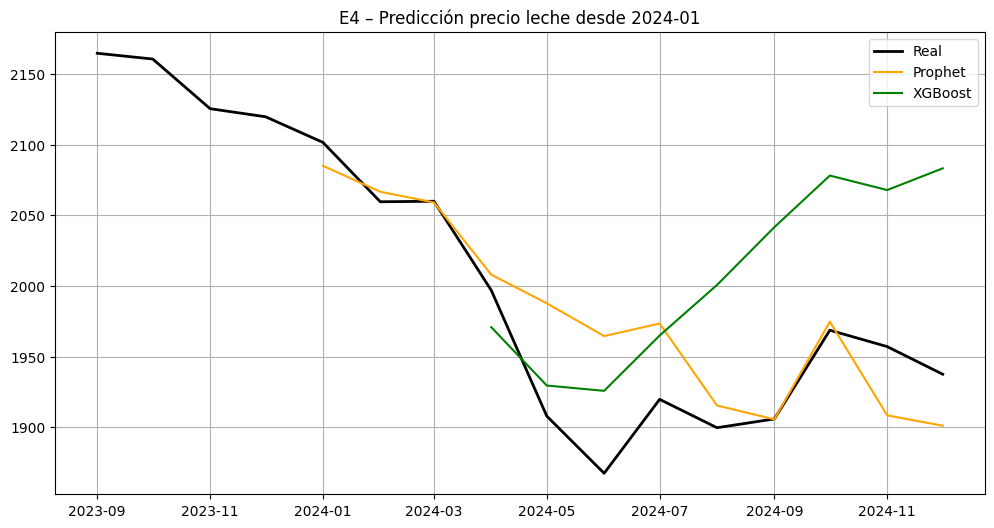

In [ ]:
# Guardar predicciones E4 y graficar desde 2024-01
y_real = E4['LECHE']

# Prophet: predicciones almacenadas en predicciones['E4 Gasolina'][3] (array con últimos 12 valores)
prophet_vals = predicciones['E4 Gasolina'][3]
prophet_idx = y_real.index[-len(prophet_vals):]
prophet_pred = pd.Series(prophet_vals, index=prophet_idx, name='Prophet')

# XGBoost: predicciones con índice res_xgb_E4['X_test'].index
xgb_pred = pd.Series(res_xgb_E4['pred'], index=res_xgb_E4['X_test'].index, name='XGBoost')

# Unificar (alinear por fecha)
df_preds = pd.concat([y_real.rename('Real'), prophet_pred, xgb_pred], axis=1)

# Filtrar desde 2024-01-01 y guardar CSV
df_preds_2024 = df_preds.loc[df_preds.index >= '2023-09-01']
df_preds_2024.to_csv('Resultados/predicciones_E4_2024_onwards.csv', index=True)
print('CSV guardado: predicciones_E4_2024_onwards.csv')

# Graficar 
plt.figure(figsize=(12,6))
plt.plot(df_preds_2024.index, df_preds_2024['Real'], label='Real', color='black', linewidth=2)
if 'Prophet' in df_preds_2024.columns:
    plt.plot(df_preds_2024.index, df_preds_2024['Prophet'], label='Prophet', color='orange')
if 'XGBoost' in df_preds_2024.columns:
    plt.plot(df_preds_2024.index, df_preds_2024['XGBoost'], label='XGBoost', color='green')
plt.title('E4 – Predicción precio leche desde 2024-01')
plt.legend()
plt.grid(True)
plt.show()